#COMPSCI 546: Applied Information Retrieval
##Assignment 8: Collaborative Recommender Systems (Total : 100 points)



# Download input files


In this assignment, you will work with the MovieLens 100K dataset, which consists of 100,000  ratings corresponding to 943 users and 1682 movies/items.  Execute the two cells given below to perform the initial set-up and download the data. You can ignore the error about downloading from github.

In [ ]:

from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = True
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term
Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-tnrhr7vo
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-tnrhr7vo
  fatal: remote error:
    The unauthenticated git protocol on port 9418 is no longer supported.
  Please see https://github.blog/2021-09-01-improving-git-protocol-security-github/ for more information.
ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-tnrhr7vo Check the logs for full command output.
Done installing Altair.


In [ ]:

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


# 1. Initial Data Preparation (20 points)

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



**Sparse Representation of the Rating Matrix**

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

**Toy example**

Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



In the cell below, build a tf.SparseTensor representation of the Rating Matrix.

Here, we'll write a function that maps from our `ratings` DataFrame to a `tf.SparseTensor`.

Hint: you can select the values of a given column of a Dataframe `df` using `df['column_name'].values`.

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
   
  #============================================================================
  #enter your code here
  def conv2list(val):
    return [int(val['user_id']), int(val['movie_id'])]
  temp = ratings_df.apply(conv2list, axis=1)
  indices = temp.tolist()
  values = ratings_df['rating'].values
  #============================================================================

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

**Calculating the error**

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



**Mean Squared Error**

Write a TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Hints:
  * in this section, we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.
  * you may find [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd) and  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error) helpful.

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """

  #============================================================================
  #enter your code here
  prod = tf.matmul(user_embeddings, tf.transpose(movie_embeddings))
  y_pred = tf.gather_nd(prod, sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, y_pred)
  #============================================================================
  return loss

# 2. Adding your own ratings to the data set (10 points)

You have to add your own ratings to the data set. The ratings are values between between 1 and 5 (inclusive). You will be able to see recommendations for yourself.

Start by checking the box below. Running the next cell will authenticate you to your google Drive account, and create a spreadsheet, that contains all movie titles in column 'A'. Follow the link to the spreadsheet and take 3 minutes to rate some of the movies. Your ratings should be entered in column 'B'.

In [ ]:
# Authenticate user.
import gspread
from google.auth import default
if USER_RATINGS:
  auth.authenticate_user()
  #gc = gspread.authorize(GoogleCredentials.get_application_default())
  creds, _ = default()
  gc = gspread.authorize(creds)
  # Create the spreadsheet and print a link to it.

  try:
    sh = gc.open('MovieLens-test')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('MovieLens-test')

  worksheet = sh.sheet1
  titles = movies['title'].values
  cell_list = worksheet.range(1, 1, len(titles), 1)
  for cell, title in zip(cell_list, titles):
    cell.value = title
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/14YSd5jSI0xpemtbPlu8vNFyIa_M_fpat2v5WFjAgots/edit


Run the next  cell to load your ratings and add them to the main `ratings` DataFrame.

In [ ]:

# Load the ratings from the spreadsheet and create a DataFrame.
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  my_ratings = pd.DataFrame({
      'user_id': "943",
      'movie_id': list(map(str, my_ratings['index'])),
      'rating': list(map(float, my_ratings[1])),
  })
  # Remove previous ratings.
  ratings = ratings[ratings.user_id != "943"]
  # Add new ratings.
  ratings = ratings.append(my_ratings, ignore_index=True)
  # Add new user to the users DataFrame.
  if users.shape[0] == 943:
    users = users.append(users.iloc[942], ignore_index=True)
    users["user_id"][943] = "943"
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  ratings[ratings.user_id=="943"].merge(movies[['movie_id', 'title']])

Added your 224 ratings; you have great taste!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3. Training a Matrix Factorization model (20 points)

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

**Build a Matrix Factorization model and train it**

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)

  # SparseTensor representation of the train and test datasets.
  #============================================================================
  #enter your code here
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  #============================================================================

  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))


  #============================================================================
  #enter your code here
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  #============================================================================


  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Great, now it's time to train the model!

Go ahead and run the next cell, trying different parameters (embedding dimension, learning rate, iterations). The training and test errors are plotted at the end of training. You can inspect these values to validate the hyper-parameters.

Note: by calling `model.train` again, the model will continue training starting from the current values of the embeddings.

 iteration 1000: train_error=0.368399, test_error=1.403246

[{'test_error': 1.4032464, 'train_error': 0.36839867}]

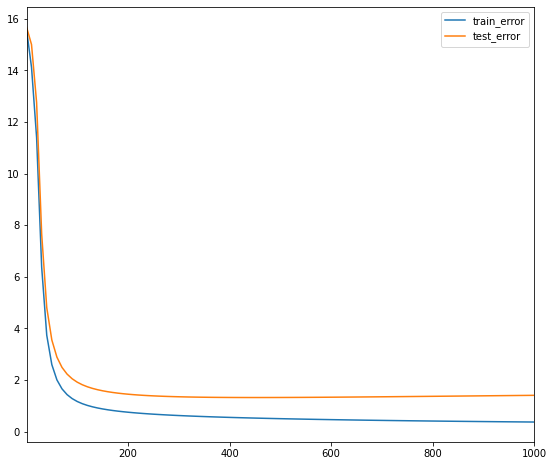

In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

# 4. Inspecting the Embeddings (30 points)

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some movies,


**Write a function that computes the scores of the candidates**

We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

As discussed in the lecture, there are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  #============================================================================
  #enter your code here
  scores = []
  for j in range(len(item_embeddings)):
    if measure == DOT:
      scores.append(np.dot(item_embeddings[j], query_embedding))
    else:
      scores.append(np.dot(item_embeddings[j], query_embedding)/
        (np.linalg.norm(query_embedding) * np.linalg.norm(item_embeddings[j])))
  #============================================================================

  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [ ]:

def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

**User recommendations**

You can run the next cell to generate recommendations for you.

In [ ]:
user_recommendations(model, measure=DOT, k=5)
user_recommendations(model, measure=COSINE, k=5)

,dot score,movie_id,titles,genres
920,7.761,920,Farewell My Concubine (1993),Drama-Romance
1225,7.599,1225,Night Falls on Manhattan (1997),Crime-Drama
1340,7.523,1340,Hedd Wyn (1992),Drama
1514,7.326,1514,Wings of Courage (1995),Adventure-Romance
625,7.235,625,So Dear to My Heart (1949),Children-Drama


,cosine score,movie_id,titles,genres
530,0.665,530,Shine (1996),Drama-Romance
920,0.638,920,Farewell My Concubine (1993),Drama-Romance
1340,0.618,1340,Hedd Wyn (1992),Drama
885,0.613,885,"Life Less Ordinary, A (1997)",Romance-Thriller
460,0.602,460,Smoke (1995),Drama


**Movie Recommendations**

Let's look at the nearest neighbors for some of the movies.

In [ ]:
movie_neighbors(model, "Braveheart", DOT, k=5)
movie_neighbors(model, "Braveheart", COSINE, k =5)

Nearest neighbors of : Braveheart (1995).


,dot score,titles,genres
21,7.591,Braveheart (1995),Action-Drama-War
68,7.003,Forrest Gump (1994),Comedy-Romance-War
63,6.750,"Shawshank Redemption, The (1994)",Drama
312,6.593,Titanic (1997),Action-Drama-Romance
514,6.356,"Boot, Das (1981)",Action-Drama-War


Nearest neighbors of : Braveheart (1995).


,cosine score,titles,genres
21,1.000,Braveheart (1995),Action-Drama-War
68,0.903,Forrest Gump (1994),Comedy-Romance-War
63,0.876,"Shawshank Redemption, The (1994)",Drama
317,0.849,Schindler's List (1993),Drama-War
27,0.849,Apollo 13 (1995),Action-Drama-Thriller


**Movie Embedding Norm**

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cells.

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [ ]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

Observe how this affects the embedding norm distribution, and the ranking of the top-norm movies?


 iteration 1000: train_error=0.353509, test_error=0.961901Nearest neighbors of : Priest (1994).


,dot score,titles,genres
56,9.902,Priest (1994),Drama
944,6.318,Charade (1963),Comedy-Mystery-Romance-Thriller
632,6.170,"Christmas Carol, A (1938)",Drama
850,6.162,Two or Three Things I Know About Her (1966),Drama
47,6.159,Hoop Dreams (1994),Documentary
1097,6.151,Flirting With Disaster (1996),Comedy


Nearest neighbors of : Priest (1994).


,dot score,titles,genres
56,4.938,Priest (1994),Drama
169,4.839,Cinema Paradiso (1988),Comedy-Drama-Romance
168,4.781,"Wrong Trousers, The (1993)",Animation-Comedy
123,4.722,Lone Star (1996),Drama-Mystery
1448,4.706,Pather Panchali (1955),Drama
407,4.702,"Close Shave, A (1995)",Animation-Comedy-Thriller


alt.HConcatChart(...)

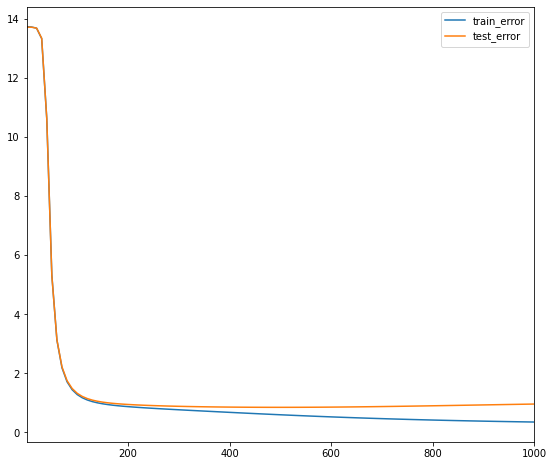

In [ ]:

#============================================================================
#enter your code here
init_stddev = 0.05
# use build_model function
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=init_stddev)
#============================================================================
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model, "Priest", DOT)
movie_neighbors(model_lowinit, "Priest", DOT)
movie_embedding_norm([model, model_lowinit])


# 5. Analytical Questions (20 points)


**Question 5.1** Describe one of the shortcomings of Collaborative Filtering models? How can one solve this issue? (10 points)

ANSWER:  
Collaborative filtering is a technique in recommender systems which can filter out items that a user might like on the basis of reactions by similar users. It searches a large group of people and finds a smaller set of users who have similar tastes with a particular user. It looks at the items that they like and combines the items and ranks them to provide suggestions to the end user.  

However, one of the shortcomings of this collaborative filtering is the problem of cold start. The recommender system will not be able to draw enough inferences for users or items, for which it has gathered very little data. The recommendation system will be unable to form any relation between users and items in such a case as no previous interactions of the users have been recorded.

Cold start problem in collaborative filtering can arise in two situations - 

1. New user added to the system and there is almost no information about the user
2. New item added to the system and there is almost no information about the item and the users who have interacted with it

One way by which this cold start problem can be dealt with, is by making the system ask the new user, to provide preferences to the items or categories that they might like or prefer to see items from. This way the recommender system will have some data to begin with. For eg - When a user first subscribes to Netflix, it asks the user to choose certain genres from which they would like to see recommendation on movies. This is one of the way by which the cold start problem with respect to new users is solved.

**Question 5.2** Properties and purposes of recommendation algorithms differ across domains. For example, in movie recommendation, the system often does not recommend the movies that the user has watched in the past, while in music recommendation, it is likely that a user listens to a music over and over. How would you modify the typical collaborative filtering models for the music domain? (10 points)

ANSWER:  
In a movie recommendation system, a movie already watched by the user is not often recommended as there is a lower chance of the user spending a couple of hours to watch it again. Instead, it recommends movies that are quite similar to what the user has previously watched (i.e. other movies in a similar genre) or recommend movies that other similar users have watched and this particular user has not watched.

However, in the music domain, the recommendation system should recommend music that the user has listened to in the past. Predominantly, songs are a couple of minutes long and there is a very high chance that the user will listen to them again and again. Here, the system collects data of the consumers comprising their listening history, skipped songs, frequency of the song being played, their social interactions like shared playlists or sharing music and many more. The system will use collaborative filtering and content based filtering in order to rank suitable songs and recommend them to the specific user. 

These recommendation systems or apps will have a section dedicated to “Music that the user may like”, which will consist of newly recommended music based on their past history and will also have a section “Music frequently listened to”, which consists of past music that the user has listened to. In music streaming apps, the “music frequently listened” to section is quite important as that’s what the users are going to look for predominantly. Here, the recommendation system has to keep track of the songs that they listened to, the songs that were skipped, how long was each song listened to and at what time of the day or during what season they listened to the song. For eg - the recommender system might not consider a song that was skipped by the user even before 30 sec of it was played. The system should also keep track of factors like at what time of the day the user listened to certain songs and recommend a similar playlist the next day during the same time. If it’s festival season like Christmas, the system should recommend songs that the user had listened to during the previous Christmas and it should not recommend it during off season (like Summer). 

By modifying the existing collaborative filtering recommendation models in the above ways, suitable recommendations can be made in the music domain.

